In [37]:
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch
import mctorch.nn as mnn
import mctorch.optim as moptim
import OurMethod
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Now we generate the example data.

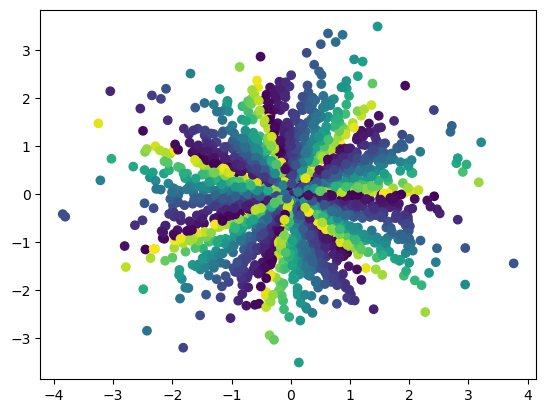

In [316]:
s1 = np.random.randn(2000, 2)
s2 = np.arctan2(s1[:, 1], s1[:, 0])
s3 = 1 / (1 + np.mod(s2, 2 * np.pi / 7))
plt.scatter(s1.transpose()[0],s1.transpose()[1],c=s3)

In [317]:
Us1 = [p[1]/p[0] for p in s1 if p[0]>0]
Vs1 = [p[0]**2+p[1]**2 for p in s1 if p[0]>0]
col1 = [s3[i] for i in range(len(s3)) if s1[i][0]>0]

Us2 = [p[1]/p[0] for p in s1 if p[0]<0]
Vs2 = [p[0]**2+p[1]**2 for p in s1 if p[0]<0]
col2 = [s3[i] for i in range(len(s3)) if s1[i][0]<0]

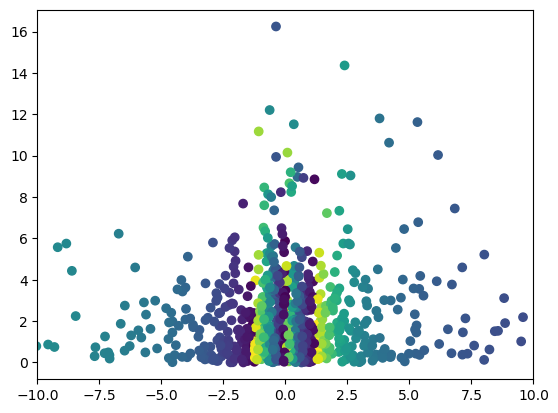

In [318]:
plt.scatter(Us1,Vs1,c=col1)
plt.xlim((-10,10))
plt.show()

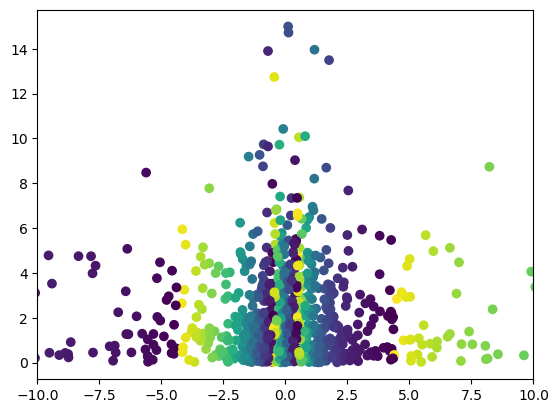

In [319]:
plt.scatter(Us2,Vs2,c=col2)
plt.xlim((-10,10))
plt.show()

In [320]:
s1t=s1.transpose()

In [321]:
T0 = time.time()
P = scipy.stats.gaussian_kde(s1t) #scipy.stats.gaussian_kde(s1t, weights=s3**24) #scipy.stats.gaussian_kde(X2t, bw_method=5)
probs = P.pdf(s1t)
T1 = time.time()
Time = T1-T0

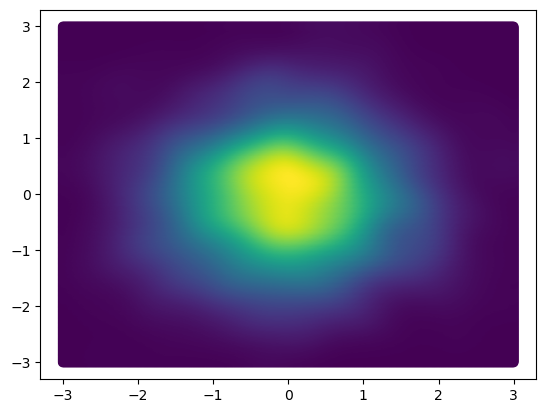

In [322]:
xs = np.linspace(-3,3,400)
Xs, Ys = np.meshgrid(xs, xs)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
#grid = np.array([grid[0],grid[1],[1 for i in range(grid.shape[1])]])
gridProbs = P.pdf(grid)
plt.scatter(grid[0], grid[1], c=gridProbs)

In [323]:
grads = np.array([scipy.optimize.approx_fprime(point, P.pdf) for point in s1])

In [324]:
Grads = grads.reshape((grads.shape[0], 1, grads.shape[1]))

In [325]:
poly = PolynomialFeatures(1, include_bias=True)

In [326]:
B = poly.fit_transform(s1)

In [327]:
Btens = torch.tensor(B).float()
GradsTens = torch.tensor(Grads).float()

In [328]:
extB = OurMethod.getExtendedFeatureMatrix2(Btens,GradsTens,2)

In [329]:
t1 = OurMethod.tryDim(extB,1,n_epochs=1000,criterion=torch.nn.L1Loss(),optimizer=moptim.rAdagrad)

/home/ben/Documents/LieGAN/OurMethod.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Btensor = torch.tensor(B).float()


In [330]:
t1

(0.006832910235971212,
 Parameter containing:
 tensor([[ 0.0150],
         [ 0.0069],
         [-0.6867],
         [-0.0012],
         [ 0.7267],
         [ 0.0080]], requires_grad=True))

In [331]:
def getJacMat(featFunc,X): #Jacobian at a single point.
    #w = self.params
    dim = featFunc.n_features_in_
    from sympy import symbols
    from sympy import Matrix
    from sympy import lambdify
    # create sympy symbols.
    exec(",".join(list(featFunc.get_feature_names_out()[1:dim+1])) + '= symbols(" ".join(list(featFunc.get_feature_names_out()[1:dim+1])))')
    # Fix things: no x0^2 and such.
    p1 = ",".join(list(featFunc.get_feature_names_out()))
    p2 = p1.replace(" ", "*")
    p3 = p2.replace("^", "**")
    p3a = list(eval(p3))
    p4 = Matrix(p3a)
    # Define the jacobian and make it a numpy array.
    J = p4.jacobian(Matrix(p3a[1:dim+1]))
    #print(J)
    Jnp = lambdify([p3a[1:dim+1]],J)
    #print(self.params.transpose()@J)
    #realJ = self.params.transpose()@Jnp(x)
    bigJ = np.array([Jnp(x) for x in X])
    return bigJ #realJ

In [332]:
poly2 = PolynomialFeatures(2) # features of the invariant function...

In [333]:
B2 = poly2.fit_transform(s1)

In [334]:
poly2.get_feature_names_out()

array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2'], dtype=object)

In [335]:
jacMat = getJacMat(poly2,s1)
jacMat.shape

(2000, 6, 2)

In [336]:
jacMat

array([[[ 0.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 0.        ,  1.        ],
        [ 3.13498656,  0.        ],
        [-0.40649105,  1.56749328],
        [ 0.        , -0.81298211]],

       [[ 0.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 0.        ,  1.        ],
        [-0.01680691,  0.        ],
        [-0.36030964, -0.00840345],
        [ 0.        , -0.72061928]],

       [[ 0.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 0.        ,  1.        ],
        [ 1.41530598,  0.        ],
        [ 0.1164791 ,  0.70765299],
        [ 0.        ,  0.2329582 ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 0.        ,  1.        ],
        [-1.17177646,  0.        ],
        [ 0.529953  , -0.58588823],
        [ 0.        ,  1.059906  ]],

       [[ 0.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 0.        ,  1.        ],
       

In [337]:
JacMat = torch.tensor(jacMat).float()

In [338]:
# the next "B" matrix is for the vector field.

In [341]:
def getExtendedFeatureMatrix3(B,J,dim):
    n = B.shape[0]
    m = B.shape[1]
    ExtArray = []
    for j in range(n):
        newBthing = np.append(B[j],np.zeros((dim-1)*m))
        Barray = np.array([np.roll(newBthing,i*m) for i in range(dim)])
        Barray = torch.tensor(Barray).float()
        thing = torch.matmul(J[j], Barray)
        ExtArray.extend([thing])
        
    #ExtArray = torch.stack(ExtArray, dim=0)
    ExtArray = torch.stack(ExtArray,dim=0) #np.array(ExtArray)
    #ExtArray = torch.tensor(ExtArray)
    return ExtArray

In [342]:
B.shape

(2000, 3)

In [343]:
extJB = getExtendedFeatureMatrix3(B,JacMat,2)

In [344]:
extJB.shape

torch.Size([2000, 6, 6])

In [345]:
finalMat = torch.matmul(extJB, t1[1].detach())
finalMat.shape

torch.Size([2000, 6, 1])

In [346]:
finalMat = finalMat.reshape((finalMat.shape[0],finalMat.shape[1]))
finalMat.shape

torch.Size([2000, 6])

In [347]:
tee1 = OurMethod.tryDim(finalMat,1)

/home/ben/Documents/LieGAN/OurMethod.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Btensor = torch.tensor(B).float()


In [348]:
tee1

(0.0006172737339511514,
 Parameter containing:
 tensor([[-0.5851],
         [ 0.0026],
         [ 0.0230],
         [-0.5895],
         [ 0.0008],
         [-0.5564]], requires_grad=True))

In [349]:
ex1 = tee1[1].detach().numpy()

In [350]:
ex1 = ex1.reshape(ex1.shape[0])

In [351]:
myF = OurMethod.invf(ex1,poly2,s1)

In [352]:
MyF = OurMethod.invf(tee1[1].detach(),poly2,s1)

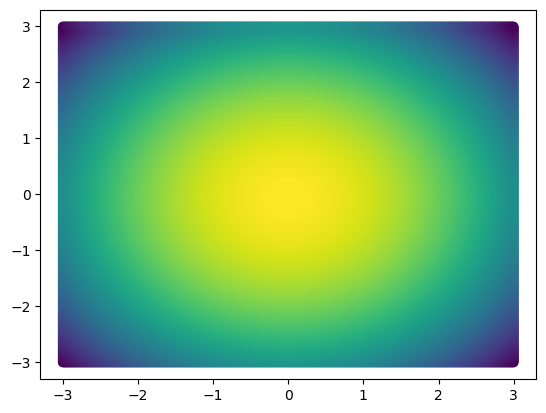

In [353]:
xs = np.linspace(-3,3,400)
Xs, Ys = np.meshgrid(xs, xs)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
gridT = grid.transpose()
PsuProbs = myF.f(np.array([grid[0],grid[1]]).transpose())
plt.scatter(grid[0], grid[1], c=PsuProbs)

In [354]:
t1

(0.006832910235971212,
 Parameter containing:
 tensor([[ 0.0150],
         [ 0.0069],
         [-0.6867],
         [-0.0012],
         [ 0.7267],
         [ 0.0080]], requires_grad=True))

In [355]:
rsq = myF.f(s1)

In [395]:
thetas = np.arctan2(s1t[1],s1t[0])

In [408]:
X2 = np.array([thetas,rsq]).transpose()
X2

array([[-0.25373621, -2.13132417],
       [-1.59411497, -0.66569815],
       [ 0.16313639, -0.88329152],
       ...,
       [ 2.40628087, -0.93328523],
       [-2.6939064 , -1.55450315],
       [-2.90601647, -2.75042169]])

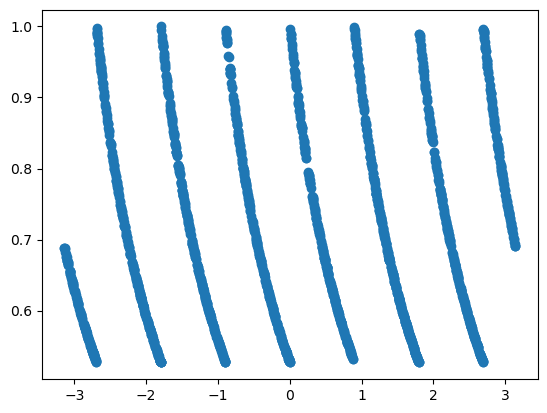

In [397]:
plt.scatter(thetas,s3)

In [401]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [399]:
RF = RandomForestRegressor()

In [404]:
X_train, X_test, y_train, y_test = train_test_split(s1,s3,test_size=0.2)

In [405]:
rf = RF.fit(X_train,y_train)

In [406]:
rf.score(X_test,y_test)

0.5965358293226604

In [407]:
rf.score(X_train,y_train)

0.9488401007462904

In [409]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,s3,test_size=0.2)

In [410]:
RF2 = RandomForestRegressor()
rf2=RF.fit(X2_train, y2_train)

In [411]:
rf2.score(X2_test,y2_test)

0.9965326751990742

In [412]:
rf2.score(X2_train,y2_train)

0.9974518161440016

In [356]:
themean = np.mean(rsq) # this will be our target value.
themean

-1.7540061621312402

In [365]:
def shrinkPt(i,threshold=0.01,lr=0.1,maxiters=10):
    oldpt = s1[i]
    iters = 0
    while abs(myF.f([oldpt])-themean) > threshold:
        newpt = oldpt-lr*myF.jacf(oldpt)*np.abs(myF.f([oldpt])-themean)
        oldpt=newpt
        iters+=1
        if iters>maxiters:
            return oldpt
        
    return oldpt

In [366]:
shrunkpts = []
for i in range(5): #range(s1.shape[0]):
    shrunkpts.extend([shrinkPt(i)])
    if i%100==0:
        print(i)

shrunkpts=np.array(shrunkpts)

0


/tmp/ipykernel_896295/924016594.py:5: RuntimeWarning: overflow encountered in multiply
  newpt = oldpt-lr*myF.jacf(oldpt)*np.abs(myF.f([oldpt])-themean)
/home/ben/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [361]:
spT = shrunkpts.transpose()

In [364]:
myF.f(s1)

array([-2.13132417, -0.66569815, -0.88329152, ..., -0.93328523,
       -1.55450315, -2.75042169])

In [363]:
myF.f(shrunkpts)

array([-2.32459492, -0.68993942, -0.95533811, ..., -1.00980054,
       -1.59978747, -3.62785136])

<function matplotlib.pyplot.show(close=None, block=None)>

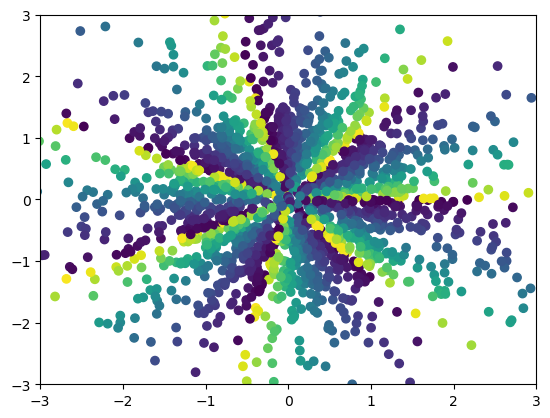

In [362]:
plt.scatter(spT[0],spT[1],c=s3)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show

In [127]:
t1

(0.005597877316176891,
 Parameter containing:
 tensor([[-0.0157],
         [ 0.0062],
         [-0.7212],
         [ 0.0240],
         [ 0.6921],
         [ 0.0069]], requires_grad=True))

In [367]:
def vfAtPoints(v,B,X):
    dim = X.shape[1]
    vecCoeffs = v.reshape(v.shape[1]*dim,v.shape[0]//dim).transpose()
    term = B@vecCoeffs
    return term

In [368]:
theVec = vfAtPoints(t1[1].detach().numpy(),B,s1)
theVec

array([[ 0.30498204,  1.13472651],
       [ 0.26237319, -0.01018356],
       [-0.06006463,  0.51404519],
       ...,
       [-0.35292433, -0.42270871],
       [ 0.38720237, -0.84350249],
       [ 0.30875045, -1.35663996]])

In [197]:
rsq = myF.f(s1)

In [225]:
themean = np.mean(rsq) # this will be our target value.
themean

-0.31010902602353146

In [200]:
myF.jacf(s1[0])

array([0.7065217 , 0.52750807])

In [201]:
theVec[0]

array([-0.61937035,  0.84413103])

In [204]:
rsq[0]

-0.2503783268214269

In [252]:
rsq[1]

0.6929835024887502

In [205]:
s1[0]

array([1.17641016, 0.84731988])

In [212]:
nextJac = MyF.Jacf(s1)

In [213]:
nextJac.shape

torch.Size([20000, 1, 2])

In [216]:
rsq

array([-0.25037833,  0.6929835 , -0.05754717, ..., -0.28796717,
       -0.30575606,  0.04709257])

In [308]:
def shrinkPt(i,threshold=0.01,lr=0.1,maxiters=5):
    oldpt = s1[i]
    iters = 0
    while abs(myF.f([oldpt])-themean) > threshold:
        newpt = oldpt-lr*myF.jacf(oldpt)*np.abs(myF.f([oldpt])-themean)
        oldpt=newpt
        iters+=1
        if iters>maxiters:
            return oldpt
        
    return oldpt

In [256]:
s1[0]

array([1.17641016, 0.84731988])

In [291]:
testpt = shrinkPt(0)
testpt

array([1.12979821, 0.8125454 ])

In [284]:
s1[1]

array([ 0.21420859, -2.30454063])

In [287]:
testpt2 = shrinkPt(1)
testpt2

array([ 0.12206906, -1.426833  ])

In [288]:
myF.f([testpt2])

array([-0.30039513])

In [289]:
myF.f([s1[0]])

array([-0.25037833])

In [292]:
myF.f([testpt])

array([-0.30065373])

In [280]:
themean

-0.31010902602353146

In [309]:
shrunkpts = []
for i in range(s1.shape[0]):
    shrunkpts.extend([shrinkPt(i)])
    if i%100==0:
        print(i)

#shrunkpts = np.array([shrinkPt(i) for i in range(s1.shape[0])])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [311]:
Shrunkpts=np.array(shrunkpts)

In [312]:
spT = Shrunkpts.transpose()

<function matplotlib.pyplot.show(close=None, block=None)>

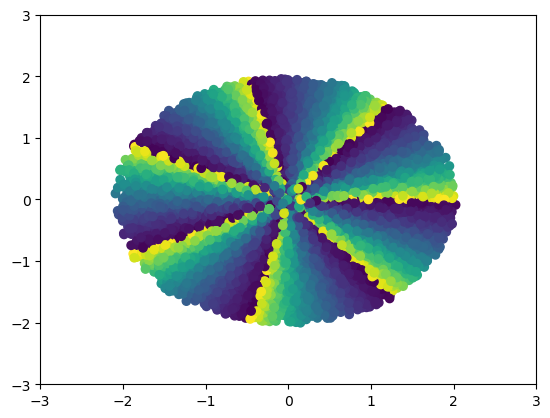

In [313]:
plt.scatter(spT[0],spT[1],c=s3)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show

In [314]:
myF.f(Shrunkpts)

array([-0.27303319,  0.06743047, -0.16934953, ..., -0.29594453,
       -0.30575606, -0.1216253 ])

In [315]:
myF.f(s1)

array([-0.25037833,  0.6929835 , -0.05754717, ..., -0.28796717,
       -0.30575606,  0.04709257])

In [369]:
#This is an expensive calculation...
def getPerp(B, d, n_epochs=100, criterion=torch.nn.MSELoss(), optimizer=moptim.rSGD, lr=1e-2):
    manifold_param = mnn.Parameter(manifold=mnn.Stiefel(B.shape[0],d))
    Btensor = torch.tensor(B).float()
    
    def model(mat):
        term1 = torch.matmul(Btensor, torch.transpose(mat,0,1))
        term2 = torch.diag(term1)
        return term2
    
    y = torch.zeros((B.shape[0],))
    
    optimizer = optimizer(params = [manifold_param], lr=lr)
    for epoch in range(n_epochs):
        y_pred = model(manifold_param)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), manifold_param

 

In [370]:
attempt1 = getPerp(theVec,2,n_epochs=100)

In [371]:
attempt1

(0.000509491132106632,
 Parameter containing:
 tensor([[-0.0185, -0.0053],
         [-0.0122, -0.0191],
         [-0.0163,  0.0064],
         ...,
         [-0.0035,  0.0081],
         [ 0.0050, -0.0238],
         [-0.0012,  0.0318]], requires_grad=True))

In [372]:
attempt1[1].shape

torch.Size([2000, 2])

In [373]:
perpVec = attempt1[1].detach().numpy()

In [374]:
es1 = [p for p in s1 if p[0]>0]
es2 = [p for p in s1 if p[0]<0]

In [379]:
perpVec1 = np.array([perpVec[i] for i in range(perpVec.shape[0]) if s1[i][0]>0])
perpVec2 = np.array([perpVec[i] for i in range(perpVec.shape[0]) if s1[i][0]<0])

In [388]:
#jacMat.shape # remember that we're assuming a quadratic function here...
poly3a = PolynomialFeatures(2)
B3a = poly3a.fit_transform(es1)
jacMat2 = getJacMat(poly3a,es1)
jacMat2.shape

(982, 6, 2)

In [389]:
thebigMat = np.array([jacMat2[i]@perpVec1[i] for i in range(perpVec1.shape[0])])
thebigMat.shape

(982, 6)

In [390]:
tee2 = OurMethod.tryDim(thebigMat,1)

In [391]:
tee2 #quadratic components.

(0.0014791176654398441,
 Parameter containing:
 tensor([[-0.3767],
         [ 0.1743],
         [ 0.0392],
         [ 0.3284],
         [ 0.3483],
         [ 0.7727]], requires_grad=True))

In [392]:
ex2 = tee2[1].detach().numpy()
ex2 = ex2.reshape(ex2.shape[0])
myF2 = OurMethod.invf(ex2,poly3a,es1)

In [393]:
theta1 = myF2.f(es1)
rsq1 = myF.f(es1)

In [193]:
theta1 = [theta[i] for i in range(len(theta)) if s1[i][0]>0]
rsq1 = [rsq[i] for i in range(len(rsq)) if s1[i][0]>0]

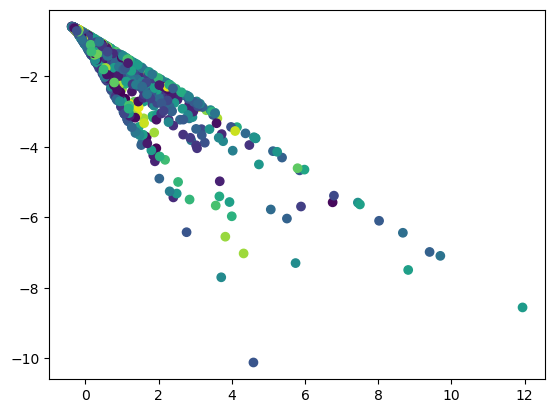

In [394]:
plt.scatter(theta1,rsq1,c=col1)
#plt.xlim((-5,5))
plt.show()

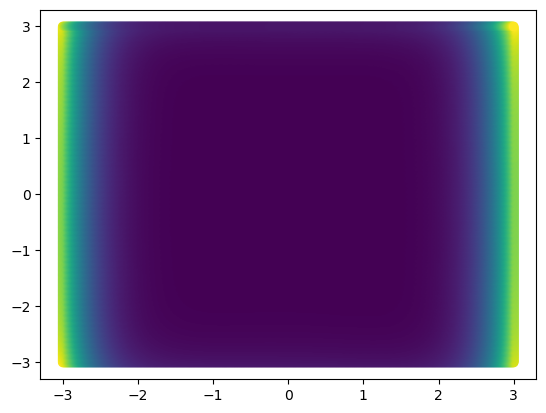

In [195]:
xs = np.linspace(-3,3,400)
Xs, Ys = np.meshgrid(xs, xs)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
gridT = grid.transpose()
PsuProbs = myF2.f(np.array([grid[0],grid[1]]).transpose())
plt.scatter(grid[0], grid[1], c=PsuProbs)

In [129]:
poly.get_feature_names_out()

array(['1', 'x0', 'x1'], dtype=object)

In [ ]:
poly.

In [130]:
B

array([[ 1.        ,  1.17641016,  0.84731988],
       [ 1.        ,  0.21420859, -2.30454063],
       [ 1.        , -1.62986956, -0.61982806],
       ...,
       [ 1.        , -1.47656267,  0.20103158],
       [ 1.        , -0.75114075,  1.20145082],
       [ 1.        ,  1.73886482,  0.32925189]])

In [131]:
test = t1[1].detach().numpy()

In [141]:
test2 = test.reshape(test.shape[1]*2,test.shape[0]//2).transpose()
test2

array([[-0.01566815,  0.02404338],
       [ 0.00624417,  0.69211763],
       [-0.72115374,  0.00693179]], dtype=float32)

In [136]:
test2[0]

array([-0.01566815, -0.72115374,  0.69211763], dtype=float32)

In [86]:
B2.shape

(20000, 6)

In [79]:
extJB.shape

torch.Size([120000, 12])

In [19]:
T0 = time.time()
P = scipy.stats.gaussian_kde(s1t, weights=s3**8) #scipy.stats.gaussian_kde(s1t, weights=s3**24) #scipy.stats.gaussian_kde(X2t, bw_method=5)
probs = P.pdf(s1t)
T1 = time.time()
Time = T1-T0

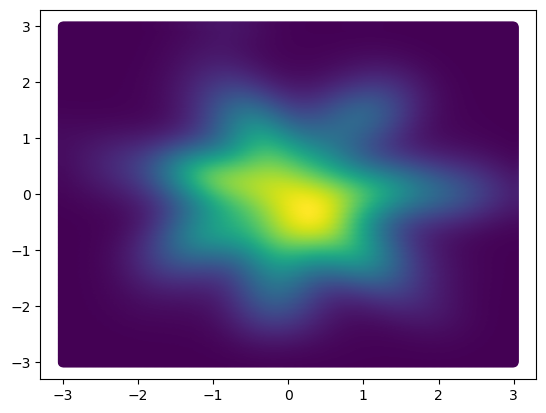

In [20]:
xs = np.linspace(-3,3,400)
Xs, Ys = np.meshgrid(xs, xs)
grid = np.vstack([Xs.ravel(), Ys.ravel()])
#grid = np.array([grid[0],grid[1],[1 for i in range(grid.shape[1])]])
gridProbs = P.pdf(grid)
plt.scatter(grid[0], grid[1], c=gridProbs)

In [21]:
def myFunc(v):
    R = np.array([[np.cos(v[0]),np.sin(v[0])],[-np.sin(v[0]),np.cos(v[0])]])
    #Rz = np.matrix([[np.cos(v[2]),np.sin(v[2]),0],[-np.sin(v[2]),np.cos(v[2]),0],[0,0,1]])
    #Rx = np.matrix([[1,0,0],[0,np.cos(v[0]),np.sin(v[0])],[0,-np.sin(v[0]),np.cos(v[0])]])
    #Ry = np.matrix([[np.cos(v[1]),0,np.sin(v[1])],[0,1,0],[-np.sin(v[1]),0,np.cos(v[1])]])
    #print(Rz)
    #print(Rx)
    #print(Ry)
    term1 = R@s1t #Rz@Rx@Ry@s1t
    term2 = P.pdf(term1)
    term3 = np.linalg.norm(term2-probs)
    return term3

In [22]:
def normcond(w):
    #p = len(w)
    term = sum(w) #sum([w[j]**2 for j in range(1)])
    return term

In [23]:
T2 = time.time()
NormCond = scipy.optimize.NonlinearConstraint(normcond, np.pi/6, np.pi)
initguess = [np.pi/4] #[1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
sol = scipy.optimize.minimize(myFunc, initguess, constraints=[NormCond])
T3 = time.time()
Time += (T3-T2)
print(Time)

0.1994764804840088


In [24]:
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.3822358622035135
       x: [ 8.333e-01]
     nit: 3
     jac: [ 1.852e-03]
    nfev: 8
    njev: 3

In [25]:
sol.x[0]/np.pi

0.26525524439339765

In [26]:
2/7

0.2857142857142857

In [27]:
2*np.pi/7-sol.x[0]

0.064273973913192